In [14]:
import sys

# Initial imports

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import datetime
from skimage import measure
from scipy import ndimage, stats
import scipy.integrate as sin
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter1d

import random
import pandas as pd
import dask.array as da
import matplotlib as mpl

import pickle

In [15]:
def cm_to_inch(m_cm):
    return m_cm/2.54

In [16]:
def find_index(time_A, time_cond):
    ind = np.where(time_A == time_cond)[0][0]
    return ind 

In [17]:
def get_all_values(dic_values):
    values = []
    for i_k, key in enumerate(dic_values.keys()):
        values.extend(dic_values[key])
    return values

Plot settings

In [18]:
fz = 9
lw = 1
siz = 3

col1 = np.array([255,126,14])/255
col2 = np.array([43,160,43])/255
col3 = np.array([31,119,179])/255

col_A = ['C0', 'C1', 'C2']

In [19]:
with open('dic_Fig2.pickle', 'rb') as handle:
    dic_Fig2 = pickle.load(handle)

In [20]:
with open('pik_times.dat', 'rb') as f:
    times_A = pickle.load(f)
times_A

[numpy.datetime64('2005-11-23T14:00:00.000000000'),
 numpy.datetime64('2005-12-04T14:00:00.000000000'),
 numpy.datetime64('2005-12-07T14:00:00.000000000')]

2005-11-23T02:00:00.000000000 2005-11-24T02:00:00.000000000
2005-12-04T02:00:00.000000000 2005-12-05T02:00:00.000000000
2005-12-07T02:00:00.000000000 2005-12-08T02:00:00.000000000


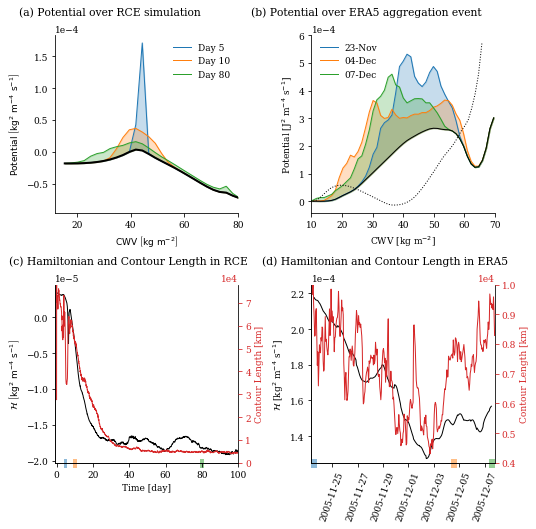

In [22]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

x_title = 0.3

fig,ax = plt.subplots(2,2,figsize=(cm_to_inch(20), cm_to_inch(20)))
plt.subplots_adjust(hspace=0.33)

ax[0,0].set_xlim((12,80))
ax[0,0].set_title('(a) Potential over RCE simulation', x=x_title, pad=20)
ax[0,0].set_xlabel(r'$\mathrm{CWV}\ \left[\mathrm{kg\ m^{-2}}\right]$')
ax[0,0].set_ylabel(r'$\mathrm{Potential\ \left[kg^{2}\ m^{-4}\ s^{-1}\right]}$')

V = dic_Fig2['V']['RCE']['V']
bin_edges = dic_Fig2['V']['RCE']['bin_edge']

for i in range(3):
    ax[0,0].fill_between(bin_edges,V,V+dic_Fig2['PDF']['RCE'][str(i+1)][0]*5e-4,color=col_A[i], alpha = 0.25)
    ax[0,0].plot(bin_edges,V+dic_Fig2['PDF']['RCE'][str(i+1)][0]*5e-4, color=col_A[i],label='Day %i'%(dic_Fig2['PDF']['RCE']['time'][i]))

ax[0,0].legend(frameon=False,loc='upper right')
ax[0,0].plot(bin_edges,V,color='k', linewidth=2)

axbis = ax[1,0].twinx()

axbis.plot(dic_Fig2['CL']['RCE']['time']/(24*3600),dic_Fig2['CL']['RCE']['CL']/1e3,color='C3')
ymin_C, ymax_C = 0, np.max(dic_Fig2['CL']['RCE']['CL'])/1e3

axbis.spines['right'].set_color('C3')
axbis.tick_params(axis='y', colors='C3')
axbis.set_ylim((ymin_C, ymax_C))
axbis.set_ylabel('Contour Length [km]',color='C3')

ax[0,0].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

ax[0,0].spines['right'].set_visible(False)
axbis.spines['right'].set_visible(False)

ax[1,0].plot(dic_Fig2['H']['RCE']['time']/(24*3600),dic_Fig2['H']['RCE']['H'],color='k')
ymin_F, ymax_F = ax[1,0].get_ylim()

trans = mtransforms.blended_transform_factory(ax[1,0].transData, ax[1,0].transAxes)
period_y_max, period_y_min = -0.03, 0.02

time = dic_Fig2['H']['RCE']['time']

for i in range(3):
    ax[1,0].fill_between(x=time/(24*3600),y1=period_y_min,y2=period_y_max,where=(time/(24*3600)<=dic_Fig2['PDF']['RCE']['time'][i]+1)&
                         (time/(24*3600)>=dic_Fig2['PDF']['RCE']['time'][i]-1), facecolor=col_A[i],alpha=0.5,transform=trans, clip_on=False)

ax[1,0].set_title('(c) Hamiltonian and Contour Length in RCE', x=x_title+0.1, pad=20)
ax[1,0].set_xlim((-0.75,100))
ax[1,0].set_ylim((ymin_F, ymax_F))
ax[1,0].set_xlabel('Time [day]')
ax[1,0].set_ylabel(r'$\mathcal{H}$ $\mathrm{\left[kg^{2}\ m^{-4}\ s^{-1}\right]}$')

ax[0,0].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax[1,0].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
axbis.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')

ax[1,0].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

#### ERA5 ####

ax[0,1].set_title('(b) Potential over ERA5 aggregation event',pad=20, x=x_title+0.00)
ax[0,1].set_xlabel(r'CWV [kg m$^{-2}$]')
ax[0,1].set_ylabel(r'Potential [J$^{2}$ m$^{-4}$ s$^{-1}$]')

ax[0,1].set_xlim(10,70)

V = dic_Fig2['V']['ERA5']['Agg']['V']
bin_edges = dic_Fig2['V']['ERA5']['Agg']['bin_edge']

for i, time_lab in enumerate(['1', '2', '3']):
    ax[0,1].fill_between(bin_edges, V, V+dic_Fig2['PDF']['ERA5'][time_lab][0]*5e-3,color=col_A[i],alpha = 0.25)
    ax[0,1].plot(bin_edges, V+dic_Fig2['PDF']['ERA5'][time_lab][0]*5e-3,color=col_A[i], label=dic_Fig2['PDF']['ERA5']['time'][i])
    
ax[0,1].plot(bin_edges, V,color='k')
ax[0,1].plot(dic_Fig2['V']['ERA5']['Dis']['bin_edge'], dic_Fig2['V']['ERA5']['Dis']['V']*0.5,color='k', linestyle='dotted')
    
nam = 'Fig2b.pdf'

ax[0,1].legend(frameon=False)

axbis = ax[1,1].twinx()
axbis.plot(dic_Fig2['CL']['ERA5']['time'], dic_Fig2['CL']['ERA5']['CL'],color='C3')
axbis.spines['right'].set_color('C3')
axbis.tick_params(axis='y', colors='C3')

axbis.set_ylabel('Contour Length [km]',color='C3')

ax[0,1].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

ax[0,1].spines['right'].set_visible(False)
axbis.spines['right'].set_visible(False)

ax[1,1].plot(dic_Fig2['H']['ERA5']['time'], dic_Fig2['H']['ERA5']['H'],color='k')
plt.setp(ax[1,1].xaxis.get_majorticklabels(), rotation=70 )

ymin_F, ymax_F = 1.25e-4, 2.25e-4 
ymin_C, ymax_C = 4e3, 1e4 

axbis.set_ylim(ymin_C, ymax_C)

trans = mtransforms.blended_transform_factory(ax[1,1].transData, ax[1,1].transAxes)

time_period = dic_Fig2['CL']['ERA5']['time']

for i, time in enumerate(times_A):

    print(time-np.timedelta64(12,'h'), time+np.timedelta64(12,'h'))
    ax[1,1].fill_between(x=time_period,y1=period_y_min,y2=period_y_max,where=(time_period<=(time+np.timedelta64(6,'h')))&(time_period>=(time-np.timedelta64(6,'h'))),
                       facecolor=col_A[i],alpha=0.5,transform=trans, clip_on = False)
    
ax[1,1].set_xlim((time_period.min(),time_period.max()))
ax[1,1].set_ylim((ymin_F, ymax_F))
ax[1,1].set_title('(d) Hamiltonian and Contour Length in ERA5', pad = 20, x=x_title+0.1)
ax[1,1].set_ylabel(r'$\mathcal{H}$ [kg$^{2}$ m$^{-4}$ s$^{-1}$]')

ax[0,1].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax[1,1].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
axbis.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')

plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

ax[1,1].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

plt.savefig('Fig2_all_rev1.pdf', bbox_inches = "tight")